# Polysemanticity

### MLP neuron activations

# 1. Imports and Model

### The transformer used in this experiment in BERT-BASE-UNCASED

In [1]:
import torch
import numpy as np
import seaborn as sns
import statistics
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel


In [2]:
# Load Pretrained Model and Tokenizer
MODEL_NAME = "bert-base-uncased"  # You can change this to any transformer model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# 2. View Architecture and Set to Evaluation Mode

In [3]:
# Set model to evaluation mode
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Background: we will be studing the linear layer in the intermediate block of the encoder. This layer transforms updated features (from attention) into a higher diimensional space (768 to 3072) in BERT.
- This layer often exhibits polysemanticity and superposition

# 3. Define Key Functions for Experiment

Store which neurons get activated after inputs:

In [4]:
# Function to collect activations from MLP layers
def collect_activations(input_texts, model, layer_to_analyze, device="cpu"):
    """
    Collect activations for neurons in a specified MLP layer.
    """
    activations = []

    def hook(module, inputs, outputs):
        activations.append(outputs.detach().cpu().numpy())

    # Get the specific MLP layer's output
    layer = model.encoder.layer[layer_to_analyze].intermediate.dense
    hook_handle = layer.register_forward_hook(hook)

    # Tokenize inputs and run through the model
    inputs = tokenizer(input_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        model(**inputs)

    hook_handle.remove()  # Clean up the hook
    return np.concatenate(activations, axis=0)  # Combine outputs


Compute statisitcs, cos similarity, and activations for neurons:

In [5]:
def analyze_activations(activations):
    """
    Compute statistical measures for neuron activations and find the two most similar neurons.
    """
    # Reshape activations to 2D: (samples * tokens, neurons)
    activations = activations.reshape(-1, activations.shape[2])

    num_neurons = activations.shape[1]

    # Compute basic statistics for neuron activations
    stats = {
        "mean": np.mean(activations, axis=0),
        "std": np.std(activations, axis=0),
        # Calculate mode using a more robust method for continuous data
        "mode": [np.histogram(activations[:, i], bins=30)[0].argmax() for i in range(num_neurons)],
    }

    # Compute correlations (Neuron * Neuron correlation matrix)
    correlations = np.corrcoef(activations.T)



    # Step 1: Normalize each vector to have unit length
    magnitudes = np.linalg.norm(activations, axis=0, keepdims=True)
    normalized_activations = activations / magnitudes  # Broadcasting for normalization

    # Step 2: Compute cosine similarity matrix
    # this works b/c all vectors are unit vectors
    cosine_sim_matrix = np.dot(normalized_activations.T, normalized_activations)

    # Step 3: Compute cosine distance matrix
    cosine_dist_matrix = 1 - cosine_sim_matrix

    # Ensure diagonal is exactly zero (self-similarity has no distance)
    np.fill_diagonal(cosine_dist_matrix, 0)

    # Find the indices of the two most similar neurons
    #np.fill_diagonal(cosine_sim_matrix, 0)  # Fill the diagonal with 0 to exclude self-similarity

    return stats, correlations, cosine_dist_matrix, activations


Correlations visualizations (threshold=0.8):

In [6]:
def find_polysemantic_neurons(correlation_matrix, threshold=0.8):
    """
    Identify polysemantic neurons based on high correlation with other neurons.
    Args:
        correlation_matrix: The neuron-neuron correlation matrix (numpy array).
        threshold: The correlation threshold above which a neuron is considered polysemantic.

    Returns:
        polysemantic_counts: A list of counts of strongly correlated neurons for each neuron.
    """
    num_neurons = correlation_matrix.shape[0]
    # Count neurons with correlation > threshold (excluding self-correlations)
    polysemantic_counts = [
        np.sum(correlation_matrix[i, :] > threshold) - 1 for i in range(num_neurons)
    ]

    return polysemantic_counts

Descriptive Statistics:

In [7]:
def compute_descriptive_stats(stats, correlations):
    """
    Compute descriptive statistics for neuron activations.
    """
    print("Statistics on number of neuron activations:")
    total_activation = activations.sum(axis=0)  # Sum activations for each neuron
    most_active_neuron = np.argmax(total_activation)  # Neuron with the highest total activation
    least_active_neuron = np.argmin(total_activation)  # Neuron with the lowest total activation
    print(f"What is the neuron INDEX with the most total activations: {most_active_neuron}")
    print(f"What is the neuron INDEX with the least total activations: {least_active_neuron}\n\n")

    print("Statistics on activation values:")
    print(f"What was the maximum mean activation value across all neurons: {max(stats['mean'])}")
    print(f"What was the minimum mean activation value across all neurons: {min(stats['mean'])}")
    print(f"What was the median average activation value across all neurons: {statistics.median(stats['mean'])}")
    print(f"What was the mean average activation value across all neurons: {statistics.mean(stats['mean'])}\n\n")

    print("Neuron Correlations:")
    polysemantic_counts = find_polysemantic_neurons(correlations)
    # Define the bins explicitly for length-5 intervals
    bins = np.arange(5, 105, 5)  # From 0 to 100 in steps of 5

    # Plot the histogram
    plt.hist(polysemantic_counts, bins=bins, edgecolor='black')
    plt.title("Distribution of Polysemantic Neurons (Length-5 Intervals)")
    plt.xlabel("Number of Strong Correlations (Grouped in 5s)")
    plt.ylabel("Frequency")
    plt.xticks(bins)  # Ensures all bin edges are labeled on the x-axis
    plt.show()



Cosine Similarity Matrix Viz:

In [8]:
def visualize_heatmap(matrix, title="Cosine Similarity Heatmap", sample_size=3072):
    """
    Visualize the cosine similarity matrix as a heatmap.

    Args:
        matrix (numpy.ndarray): Cosine similarity matrix.
        title (str): Title of the plot.
        sample_size (int): Number of rows/columns to sample for visualization.
    """
    # # Optionally sample a smaller subset if the matrix is too large
    # if matrix.shape[0] > sample_size:
    #     matrix = matrix[:sample_size, :sample_size]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='coolwarm', square=True, cbar=True)
    plt.title(title)
    #plt.xlabel("Neurons")
    #plt.ylabel("Neurons")
    plt.show()


Cosine Similarity Histogram:

In [9]:
def plot_similarity_histogram(matrix, bins=50):
    """
    Plot a histogram of the distribution of values in the cosine similarity matrix.

    Args:
        matrix (numpy.ndarray): Cosine similarity matrix.
        bins (int): Number of bins in the histogram.
    """
    # Flatten the matrix and exclude diagonal (self-similarity)
    flattened_values = matrix[np.triu_indices_from(matrix, k=1)]  # Upper triangular values only

    # Plot histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(flattened_values, bins=bins, kde=True, color="blue", alpha=0.7)
    plt.title("Distribution of Cosine Similarity Values")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency (log)") # LOG SCALE
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Plot Neuron Distributions Together:

In [10]:
def sample_and_plot_distributions(matrix, num_neurons=100):
    """
    Randomly sample neurons and plot their activation value distributions.

    Args:
        matrix (numpy.ndarray): Activation matrix of size (tokens, neurons).
        num_neurons (int): Number of neurons to randomly sample.
    """
    # Randomly sample neuron indices
    total_neurons = matrix.shape[1]
    sampled_indices = np.random.choice(total_neurons, size=num_neurons, replace=False)

    # Extract activations for sampled neurons
    sampled_activations = matrix[:, sampled_indices]  # Shape: (tokens, sampled_neurons)

    # Plot each neuron separately for clarity
    plt.figure(figsize=(12, 6))
    for i, neuron_idx in enumerate(sampled_indices):
        plt.plot(range(matrix.shape[0]), sampled_activations[:, i], label=f"Neuron {neuron_idx}", alpha=0.8)

    plt.title(f"Activation Values Across Tokens for {num_neurons} Randomly Sampled Neurons")
    plt.xlabel("Token Index")
    plt.ylabel("Activation Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(-5, 5)
    plt.tight_layout()
    plt.show()


Plot indiviudal neuron distributions:

In [11]:
def plot_individual_neurons(matrix, num_neurons=10):
    """
    Plot individual line plots for each sampled neuron.
    """
    total_neurons = matrix.shape[1]
    sampled_indices = np.random.choice(total_neurons, size=num_neurons, replace=False)

    for i, neuron_idx in enumerate(sampled_indices):
        plt.figure(figsize=(8, 4))
        plt.plot(range(matrix.shape[0]), matrix[:, neuron_idx], alpha=0.8, color="blue")
        plt.title(f"Neuron {neuron_idx}: Activation Values Across Tokens")
        plt.xlabel("Token Index")
        plt.ylabel("Activation Value")
        plt.ylim(-5, 3)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


# 4. Analysis

##Example 1: Language
"The cat sat on the mat.", <br>
"She enjoys learning new languages.", <br>
"Die Katze sitzt auf der Matte.",  # German <br>
"Sy hou van om nuwe tale te leer.",  # Afrikaans

#### Call Main Function()
The input text is english, german, and afrikaans.



In [12]:
# Main routine
if __name__ == "__main__":
    # Example text input
    text_data = [
        "The cat sat on the mat.",
        "She enjoys learning new languages.",
        "Die Katze sitzt auf der Matte.",  # German
        "Sy hou van om nuwe tale te leer.",  # Afrikaans
    ]

    layer_to_analyze = 0  # Early Transformer MLP Layer (e.g., Layer 0)
    activations = collect_activations(text_data, model, layer_to_analyze)


In [13]:
# Analyze and visualize activations
stats_lang, correlations_lang, cos_matrix_lang, activations_lang = analyze_activations(activations)


What's interesting in the heatmap is that there are some neurons that are across the baoard different from the others. This plaid pattern is unique, it seems like many neurons are polysemantic, while some are embedded as a unique idea.

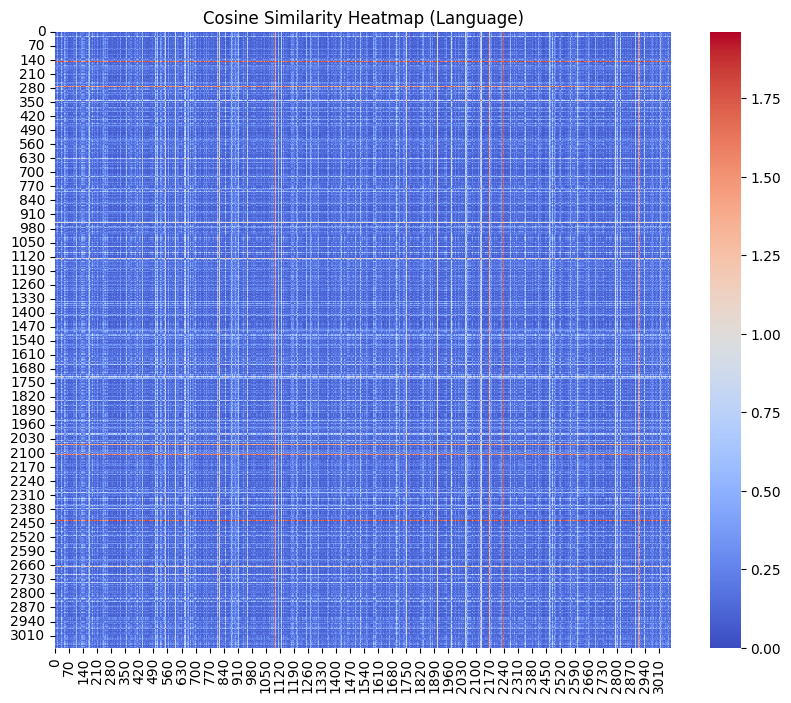

In [14]:
visualize_heatmap(cos_matrix_lang, title="Cosine Similarity Heatmap (Language)")

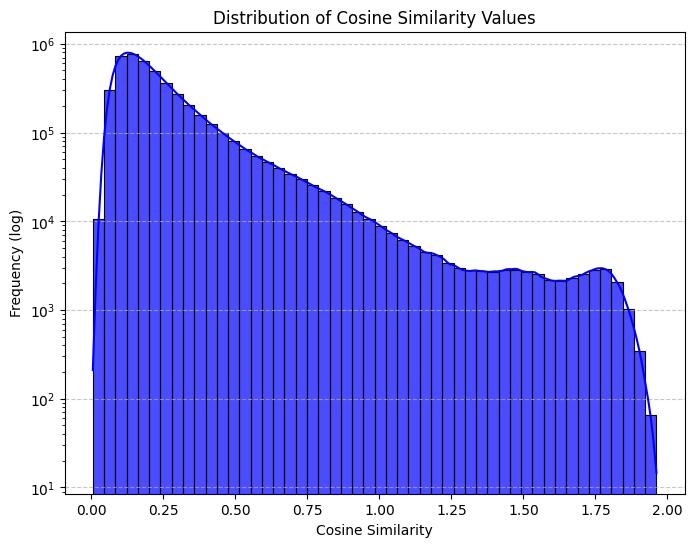

In [15]:
plot_similarity_histogram(cos_matrix_lang, bins=50)

Neuron Distributions

In [16]:
# for each of the 56 tokens, we have a correpsonding vector of length 3072. Each value in this vector is a neuron activation value.
activations_lang.shape

(56, 3072)

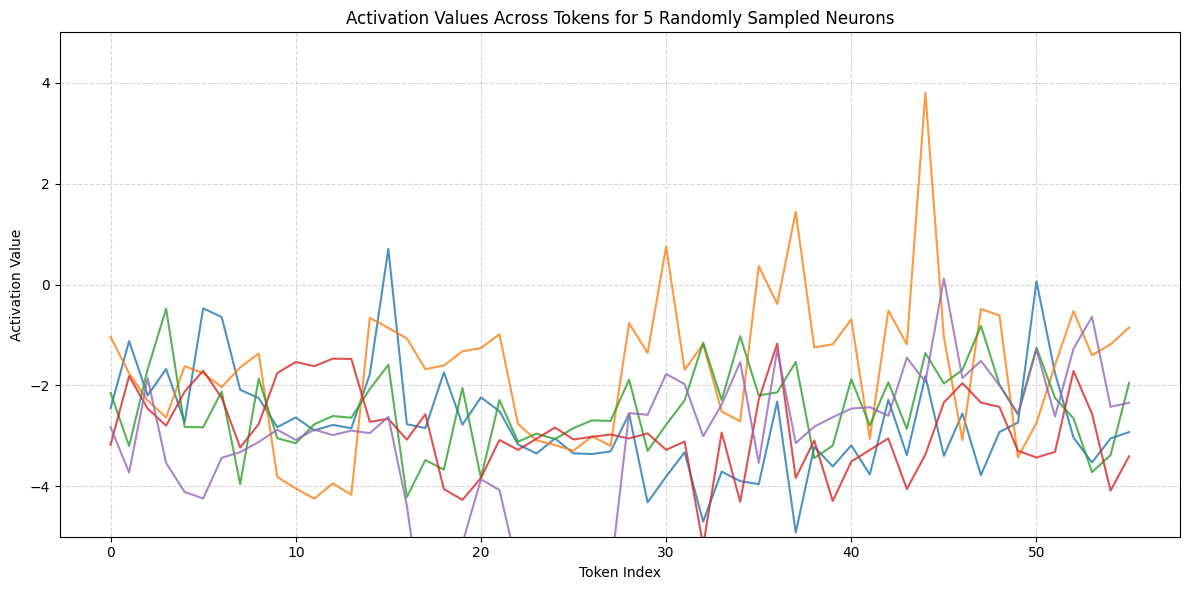

In [17]:
sample_and_plot_distributions(activations_lang, num_neurons=5)

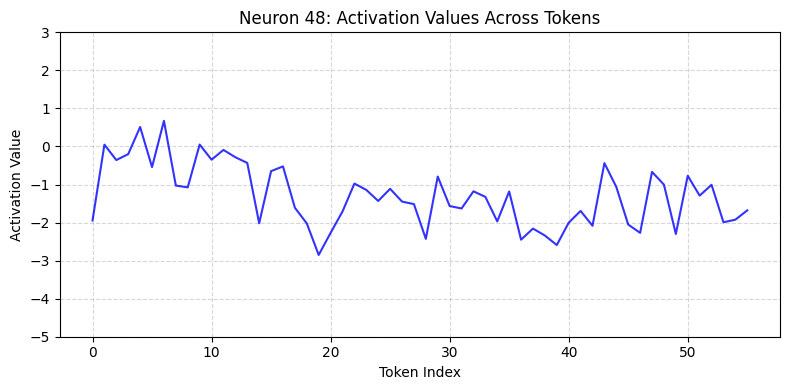

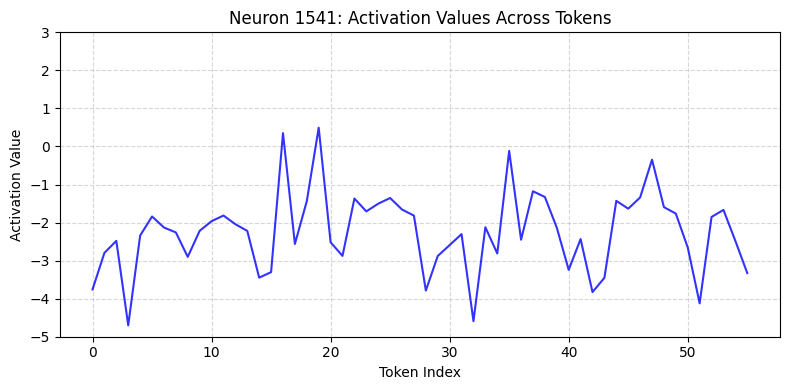

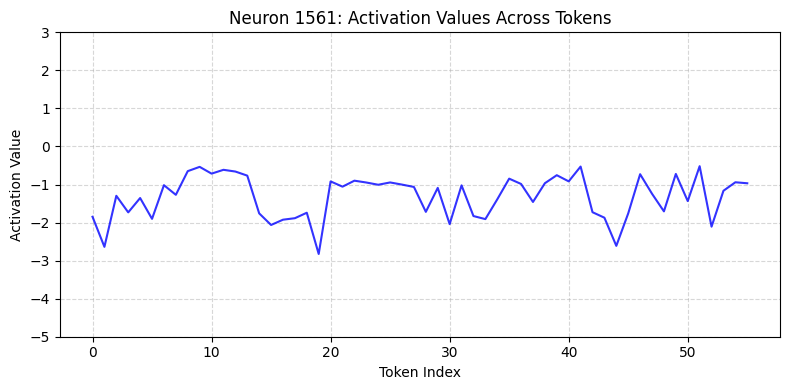

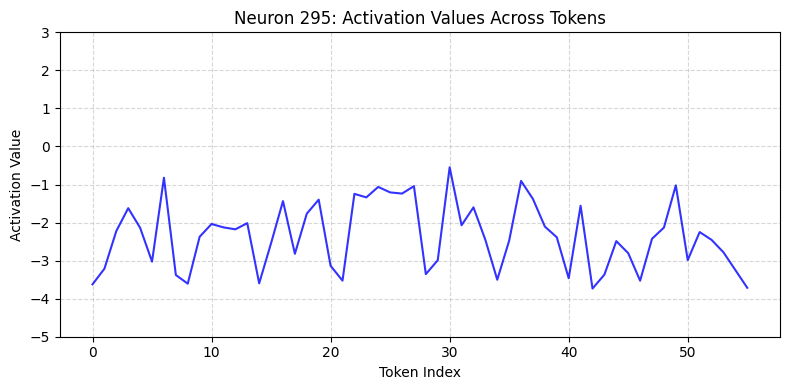

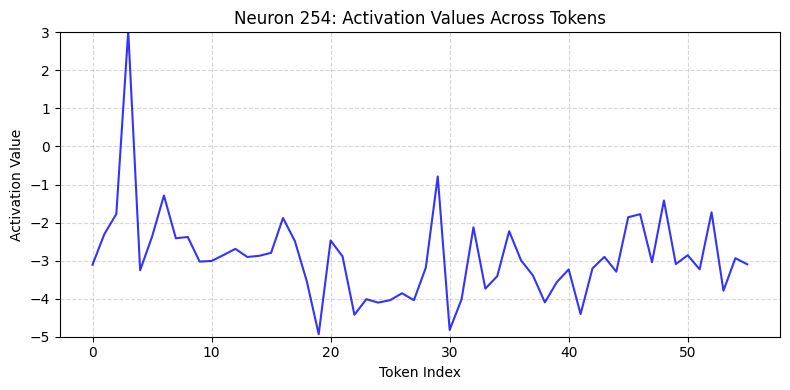

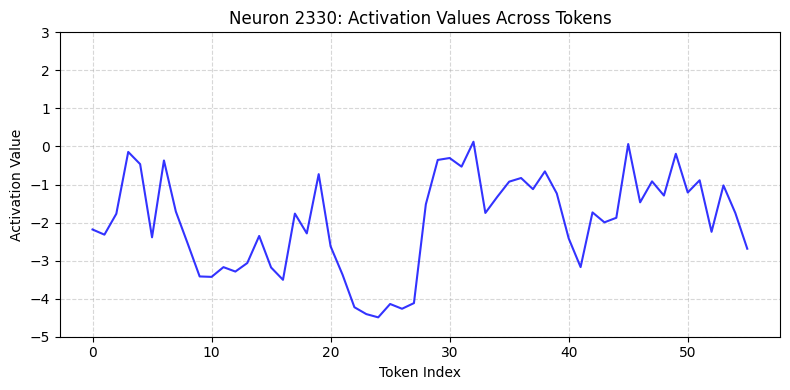

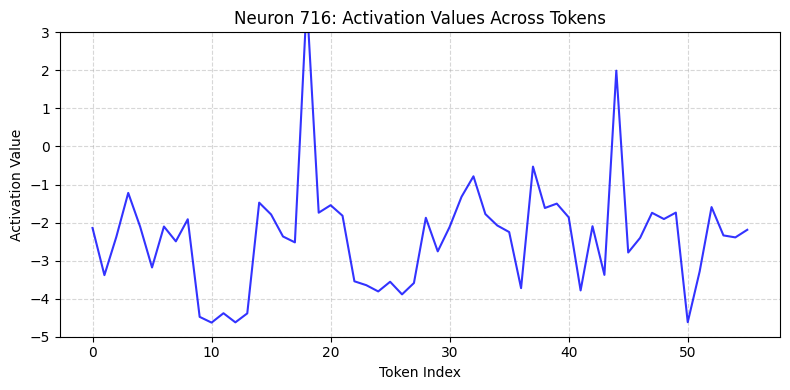

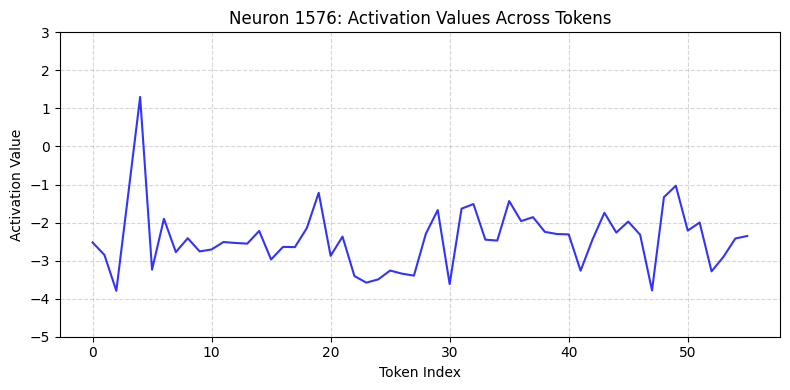

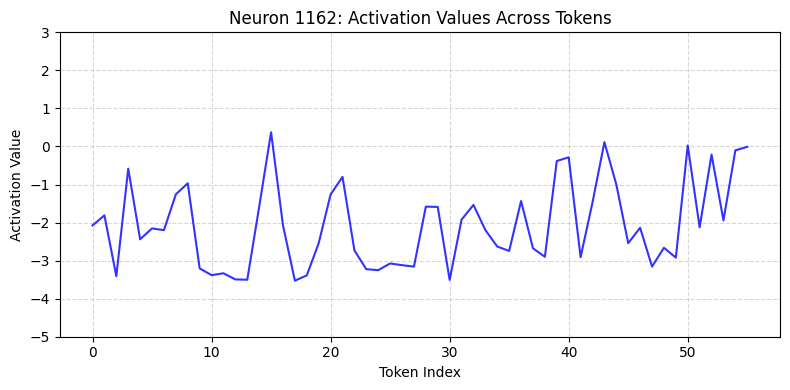

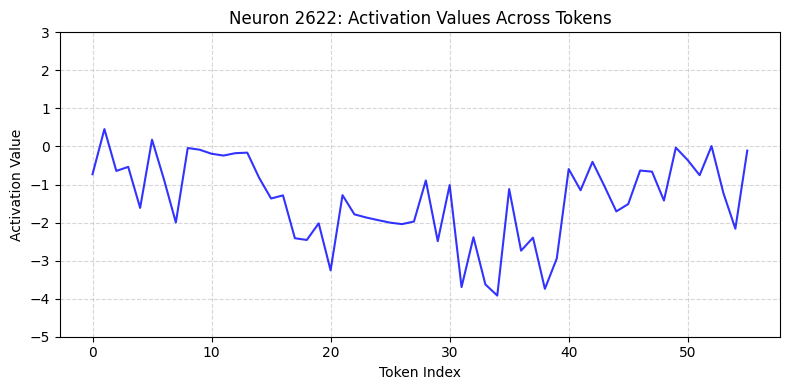

In [18]:
plot_individual_neurons(activations_lang, num_neurons=10)

Statistics on number of neuron activations:
What is the neuron INDEX with the most total activations: 1907
What is the neuron INDEX with the least total activations: 1431


Statistics on activation values:
What was the maximum mean activation value across all neurons: 1.3614413738250732
What was the minimum mean activation value across all neurons: -10.19410514831543
What was the median average activation value across all neurons: -2.258178472518921
What was the mean average activation value across all neurons: -2.19563364982605


Neuron Correlations:


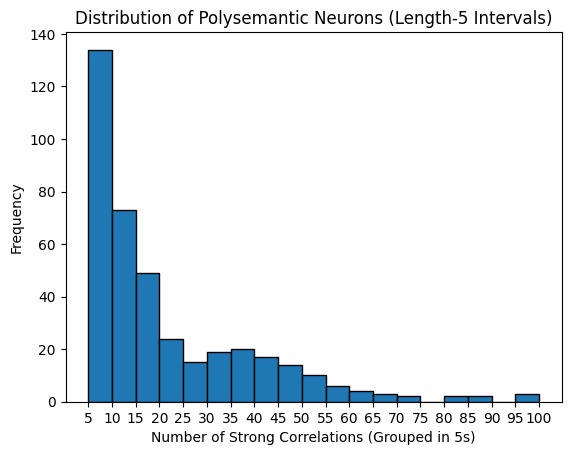

In [19]:
compute_descriptive_stats(stats_lang, correlations_lang)

## EXAMPLE 2: Math and Logic Reasoning

What is 25 plus 17? The answer is 42. <br>
A triangle with sides 3, 4, and 5 has a right angle. The area is 6. <br>
If Alice has 10 apples and gives 4 away, she has 6 apples left. <br>
The statement 'All men are mortal' is true. Socrates is a man. <br>


In [20]:
# Main routine
if __name__ == "__main__":
    # Example text input
    text_data = [
        "What is 25 plus 17? The answer is 42.",
        "A triangle with sides 3, 4, and 5 has a right angle. The area is 6.",
        "If Alice has 10 apples and gives 4 away, she has 6 apples left.",
        "The statement 'All men are mortal' is true. Socrates is a man.",
    ]

    layer_to_analyze = 0  # Early Transformer MLP Layer (e.g., Layer 0)
    activations = collect_activations(text_data, model, layer_to_analyze)


In [21]:
# Analyze and visualize activations
stats_reasoning, correlations_reasoning, cos_matrix_reasoning, activations_reasoning = analyze_activations(activations)

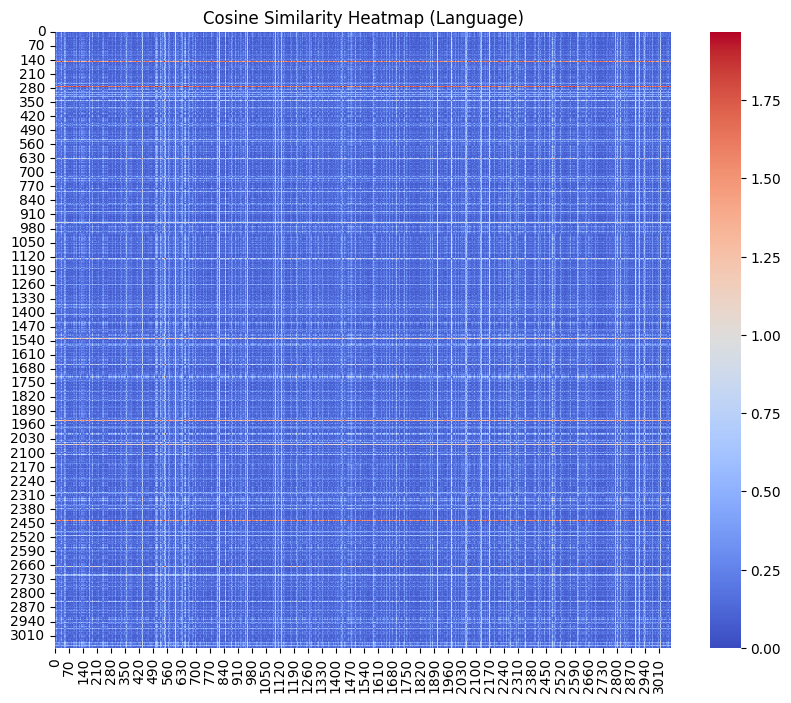

In [22]:
visualize_heatmap(cos_matrix_reasoning, title="Cosine Similarity Heatmap (Math)")

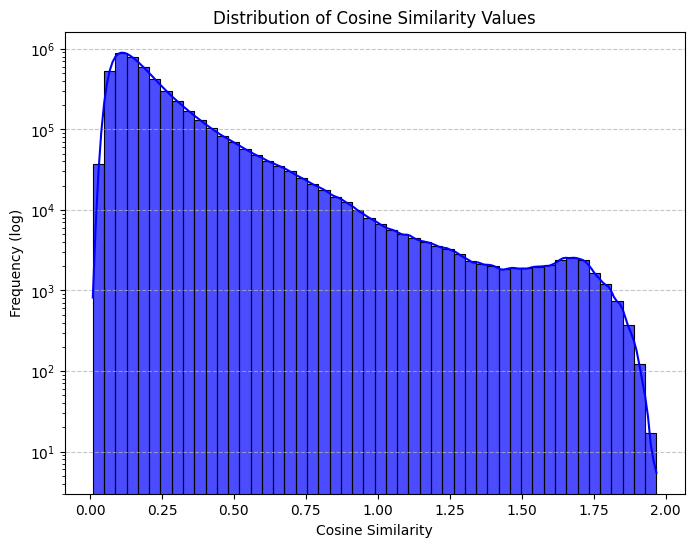

In [23]:
plot_similarity_histogram(cos_matrix_reasoning, bins=50)

In [24]:
# for each of the 56 tokens, we have a correpsonding vector of length 3072. Each value in this vector is a neuron activation value.
activations_reasoning.shape

(88, 3072)

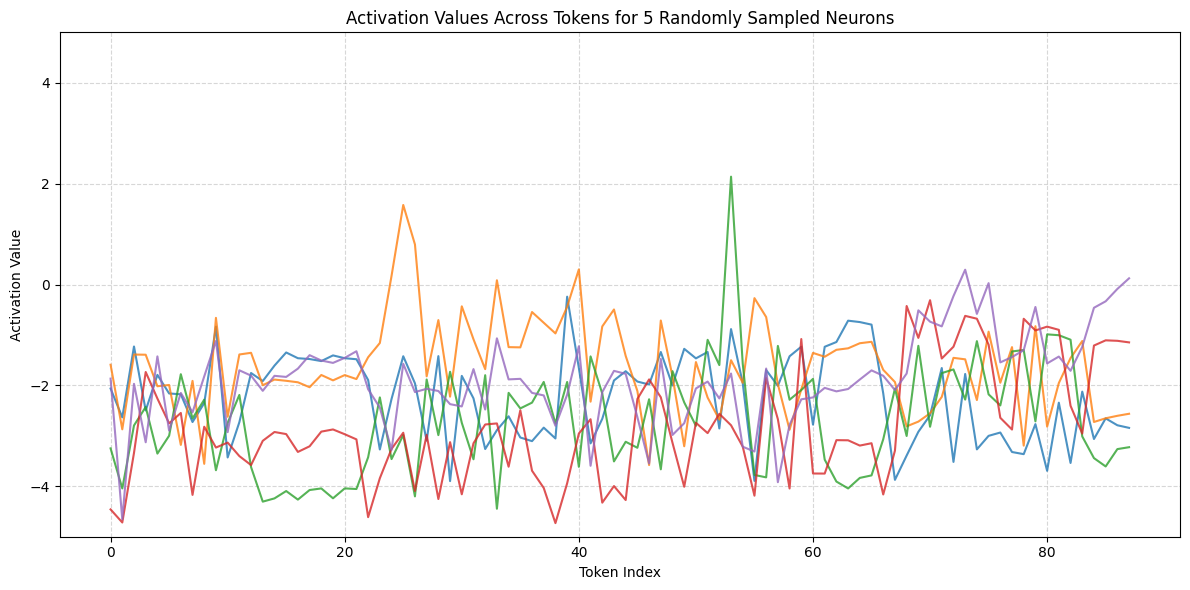

In [25]:
sample_and_plot_distributions(activations_reasoning, num_neurons=5)

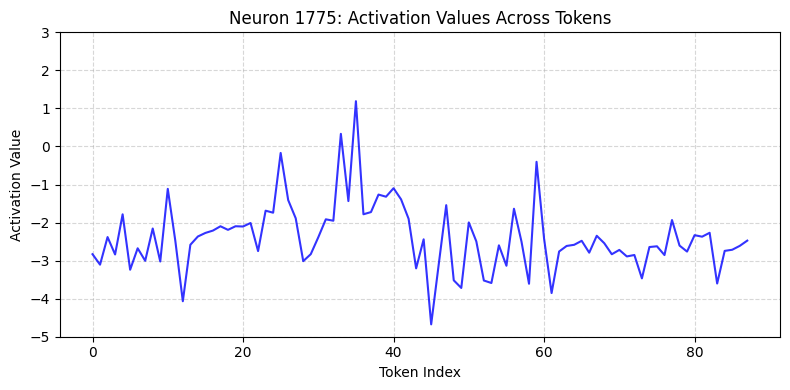

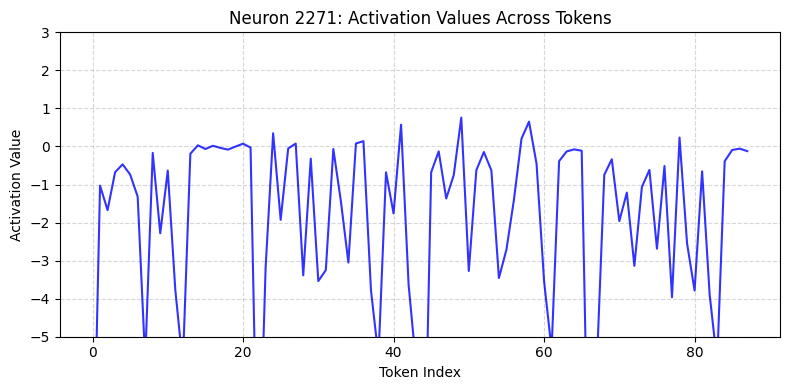

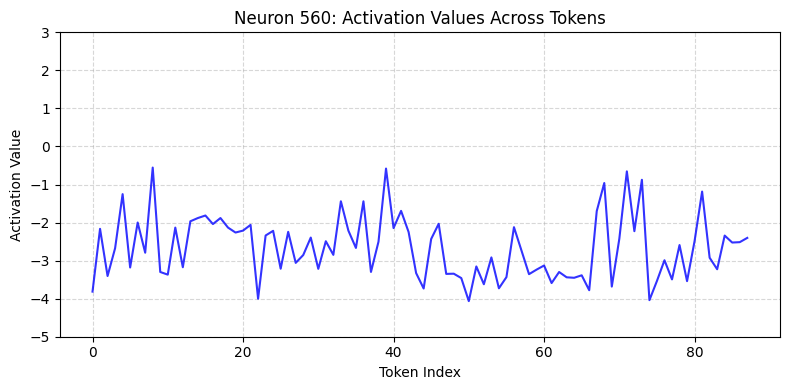

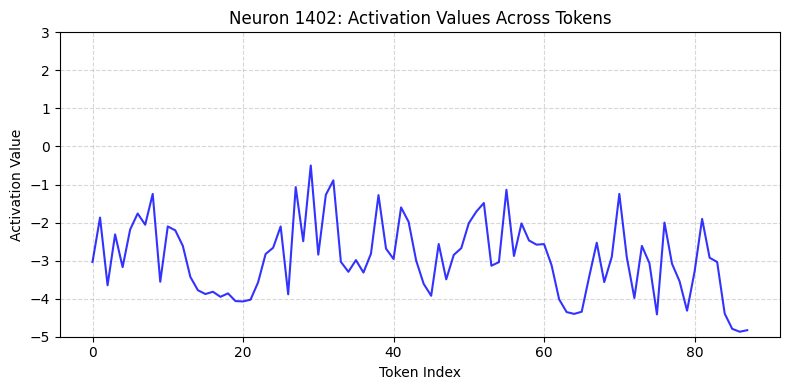

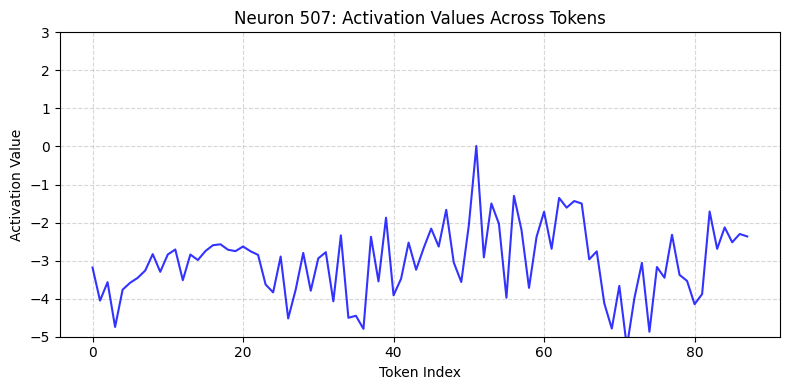

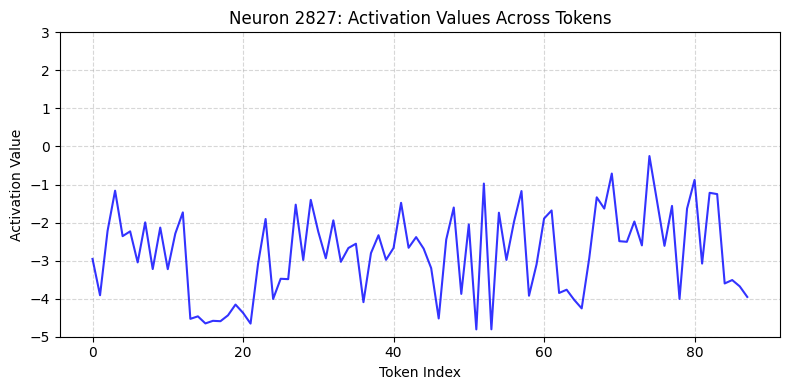

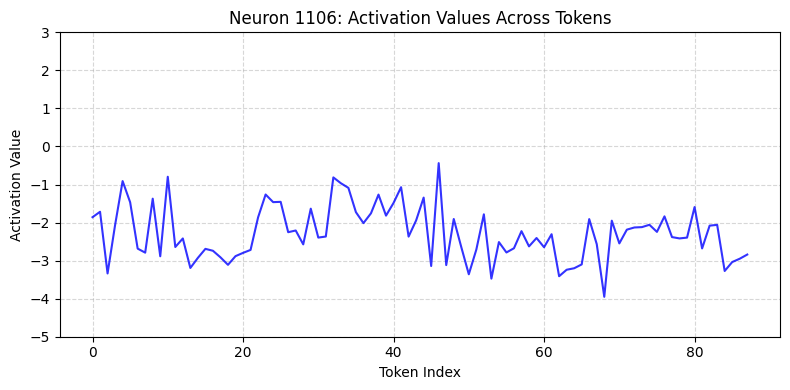

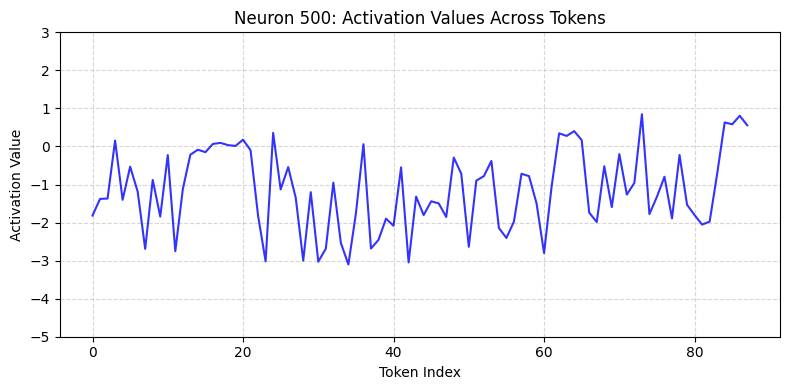

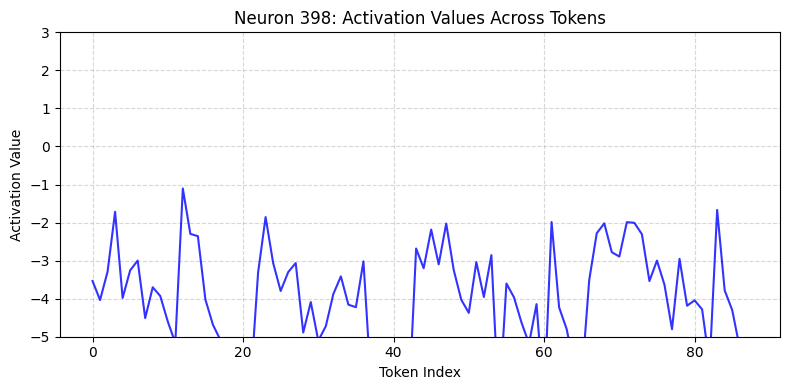

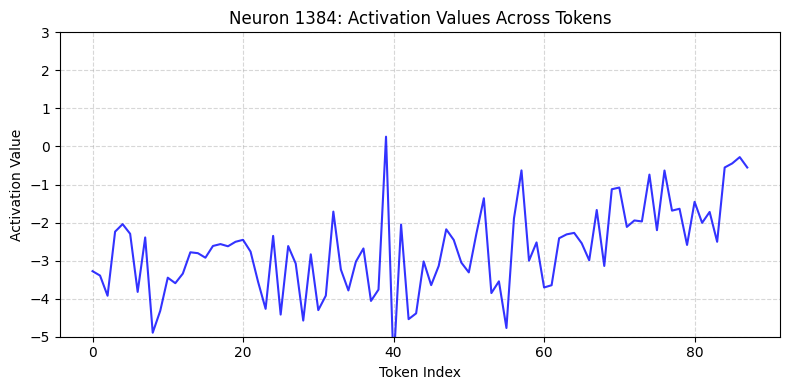

In [26]:
# Example: Visualize 10 individual neurons
plot_individual_neurons(activations_reasoning, num_neurons=10)

Statistics on number of neuron activations:
What is the neuron INDEX with the most total activations: 1907
What is the neuron INDEX with the least total activations: 1431


Statistics on activation values:
What was the maximum mean activation value across all neurons: 1.2970221042633057
What was the minimum mean activation value across all neurons: -9.977020263671875
What was the median average activation value across all neurons: -2.283944606781006
What was the mean average activation value across all neurons: -2.2435052394866943


Neuron Correlations:


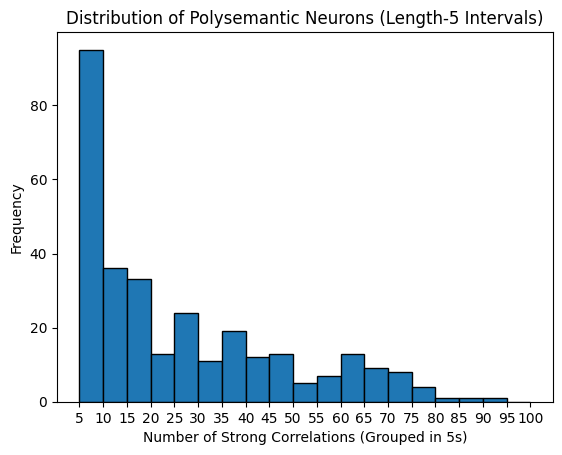

In [27]:
compute_descriptive_stats(stats_reasoning, correlations_reasoning)

In [28]:
#Frobeinus norm



# Compute the Frobenius norm between the two matrices
frobenius_norm = np.linalg.norm(cos_matrix_lang - cos_matrix_reasoning)

print("Frobenius Norm between the two matrices:", frobenius_norm)


Frobenius Norm between the two matrices: 451.8204


# Example 3: Miscellaneous
"Water boils at 100 degrees Celsius under standard conditions." <br>
"The sunset painted the sky in hues of orange and red." <br>
"I love sunny days because they make me feel energetic and happy." <br>
"Harry Potter defeated Voldemort in the Battle of Hogwarts."

In [29]:
# Main routine
if __name__ == "__main__":
    # Example text input
    text_data = [
        "Water boils at 100 degrees Celsius under standard conditions.",
        "The sunset painted the sky in hues of orange and red.",
        "I love sunny days because they make me feel energetic and happy.",
        "Harry Potter defeated Voldemort in the Battle of Hogwarts.",
    ]

    layer_to_analyze = 0  # Early Transformer MLP Layer (e.g., Layer 0)
    activations = collect_activations(text_data, model, layer_to_analyze)


In [30]:
# Analyze and visualize activations
stats_misc, correlations_misc, cos_matrix_misc, activations_misc = analyze_activations(activations)

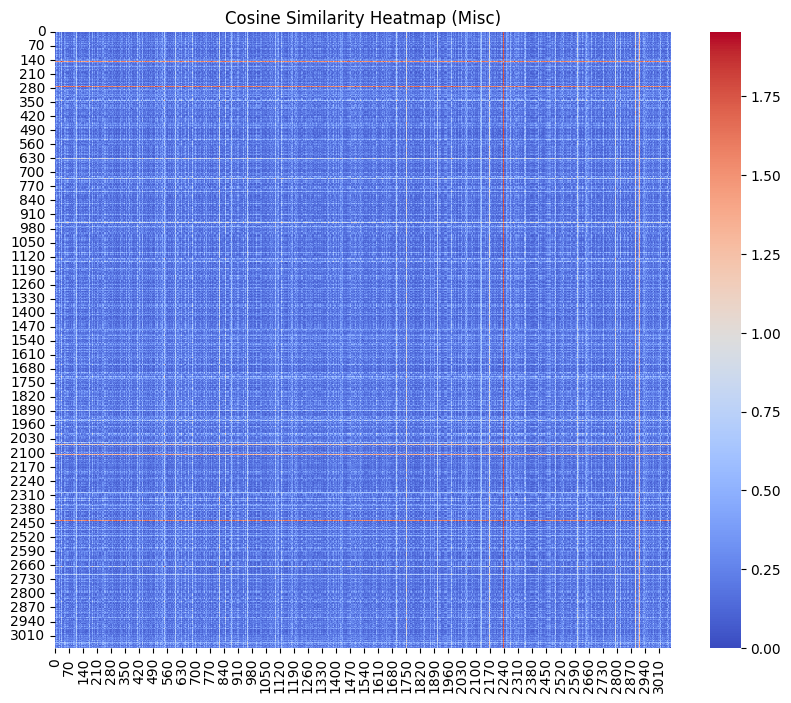

In [31]:
visualize_heatmap(cos_matrix_misc, title="Cosine Similarity Heatmap (Misc)")

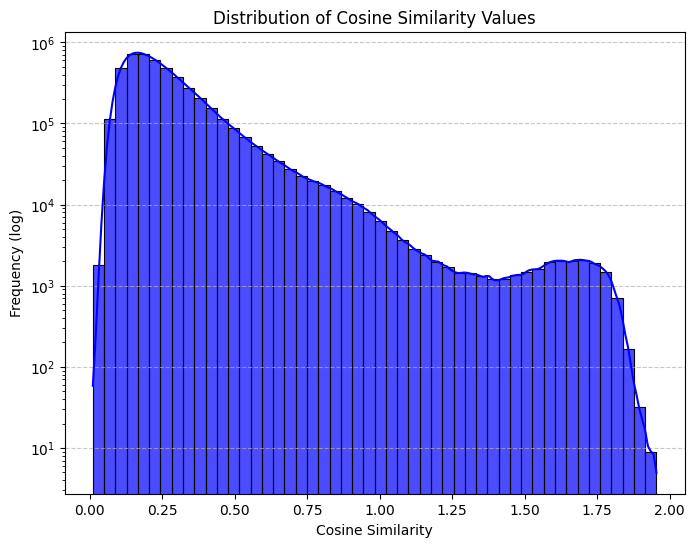

In [32]:
plot_similarity_histogram(cos_matrix_misc, bins=50)

In [33]:
# for each of the 56 tokens, we have a correpsonding vector of length 3072. Each value in this vector is a neuron activation value.
activations_misc.shape

(68, 3072)

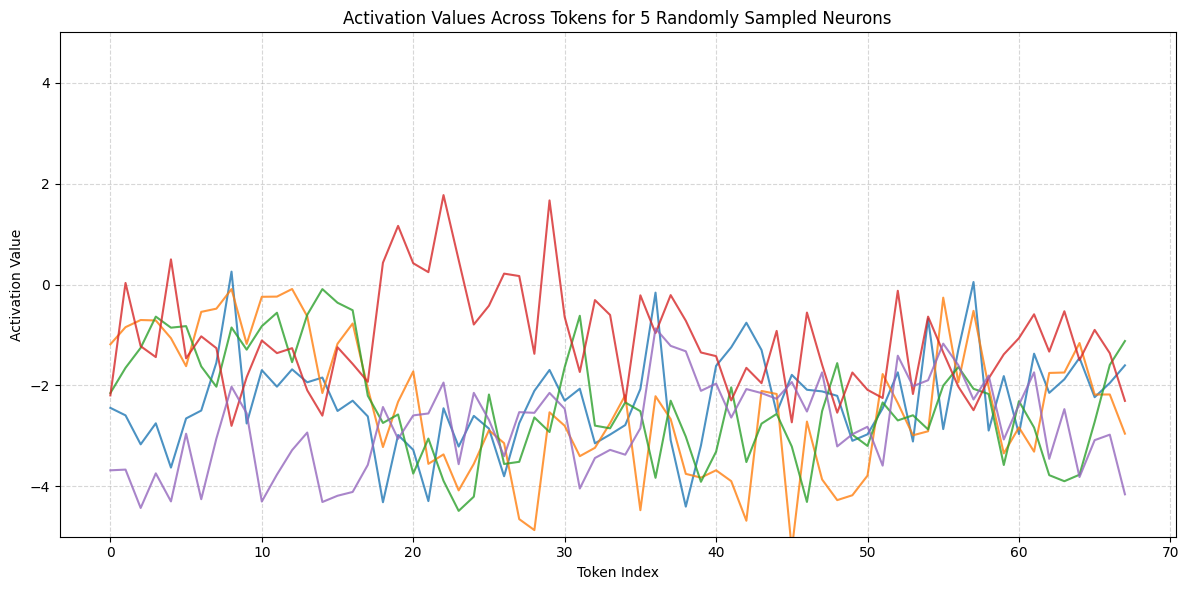

In [34]:
sample_and_plot_distributions(activations_misc, num_neurons=5)

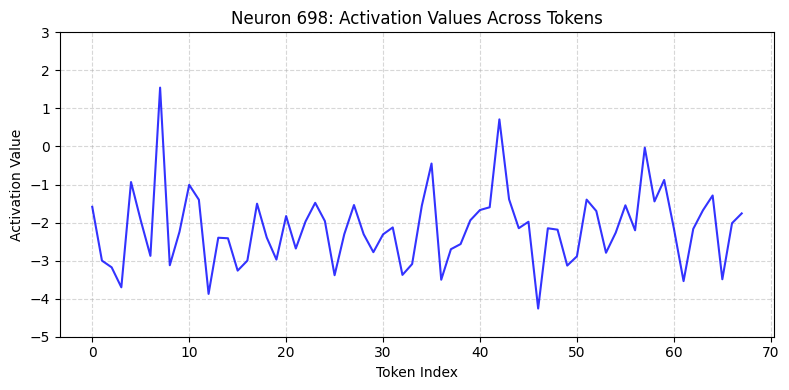

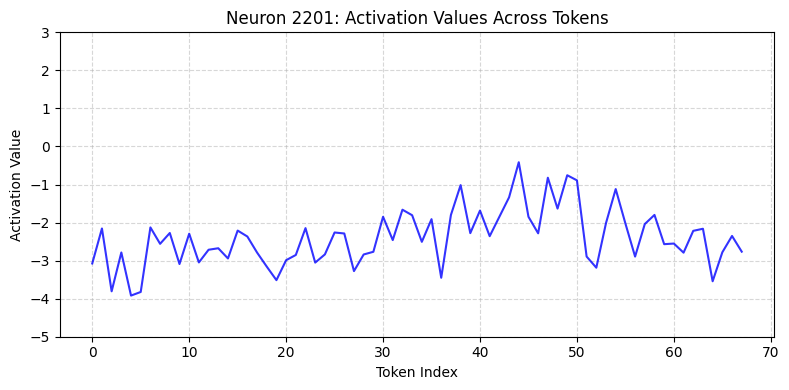

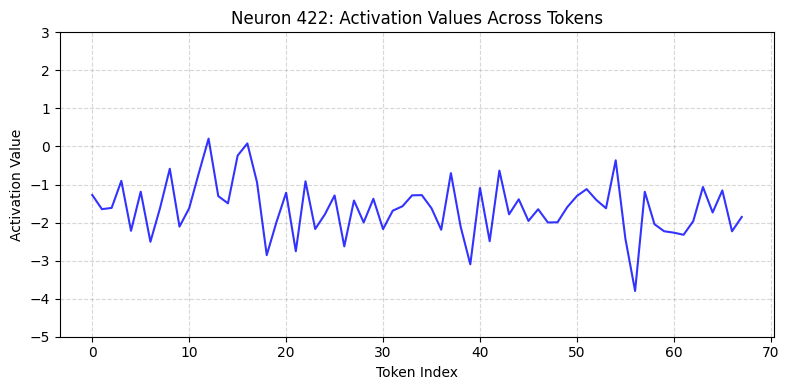

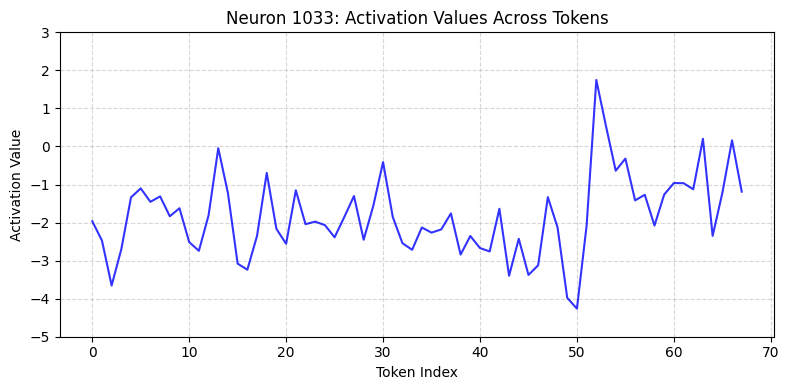

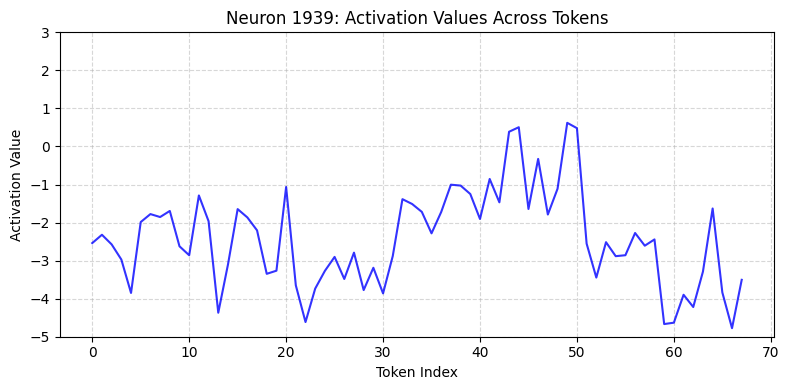

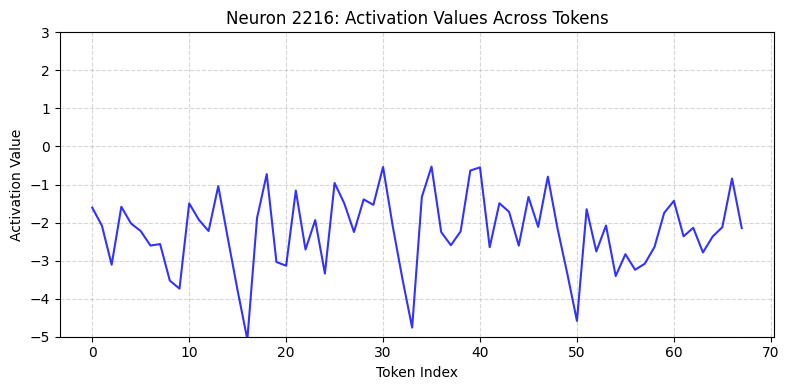

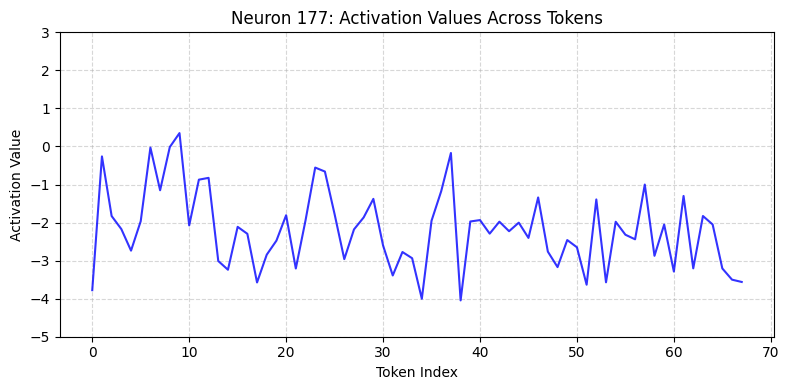

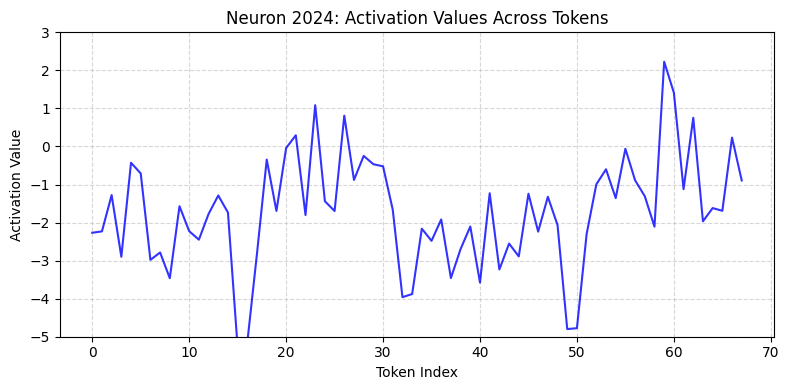

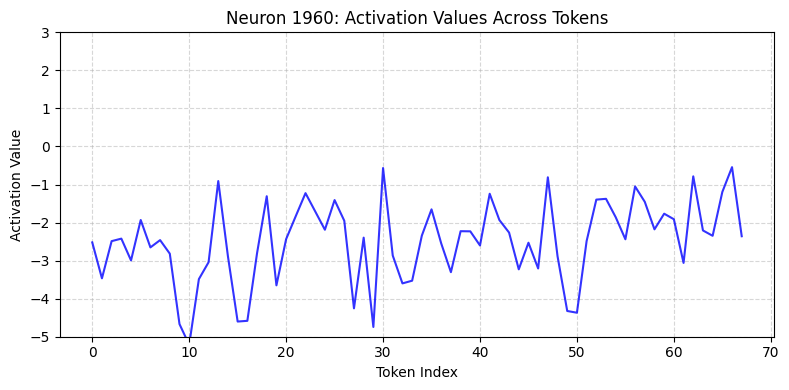

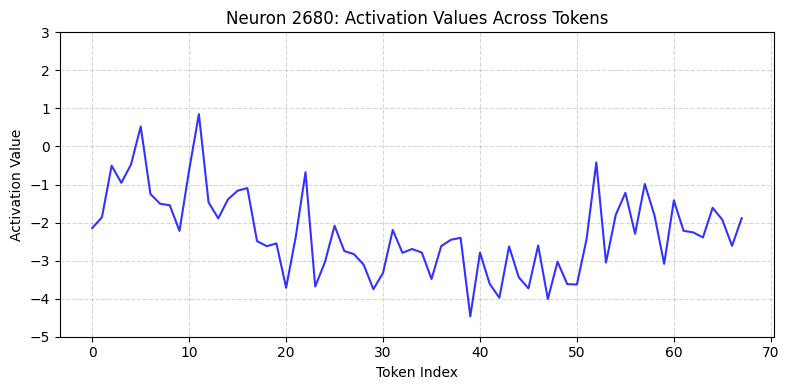

In [35]:
# Example: Visualize 10 individual neurons
plot_individual_neurons(activations_misc, num_neurons=10)

Statistics on number of neuron activations:
What is the neuron INDEX with the most total activations: 1907
What is the neuron INDEX with the least total activations: 1431


Statistics on activation values:
What was the maximum mean activation value across all neurons: 1.2945297956466675
What was the minimum mean activation value across all neurons: -9.6028470993042
What was the median average activation value across all neurons: -2.171534776687622
What was the mean average activation value across all neurons: -2.1440751552581787


Neuron Correlations:


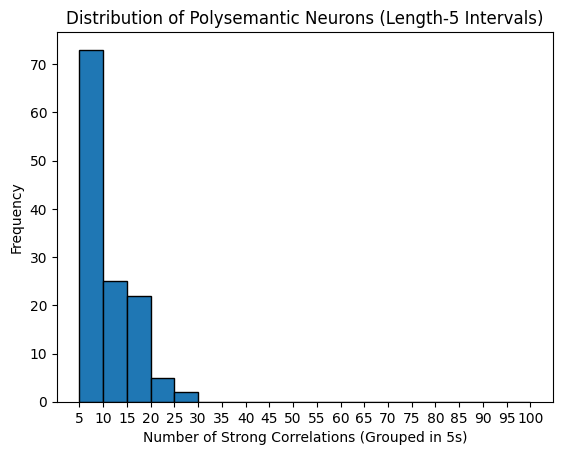

In [36]:
compute_descriptive_stats(stats_misc, correlations_misc)

## This is a histogram of summed activation values for each neuron across the 3 inputs.

In [38]:
total_activation = activations_lang.sum(axis=0) + activations_reasoning.sum(axis=0) + activations_misc.sum(axis=0)  # Sum activations for each neuron
total_activation.shape

(3072,)

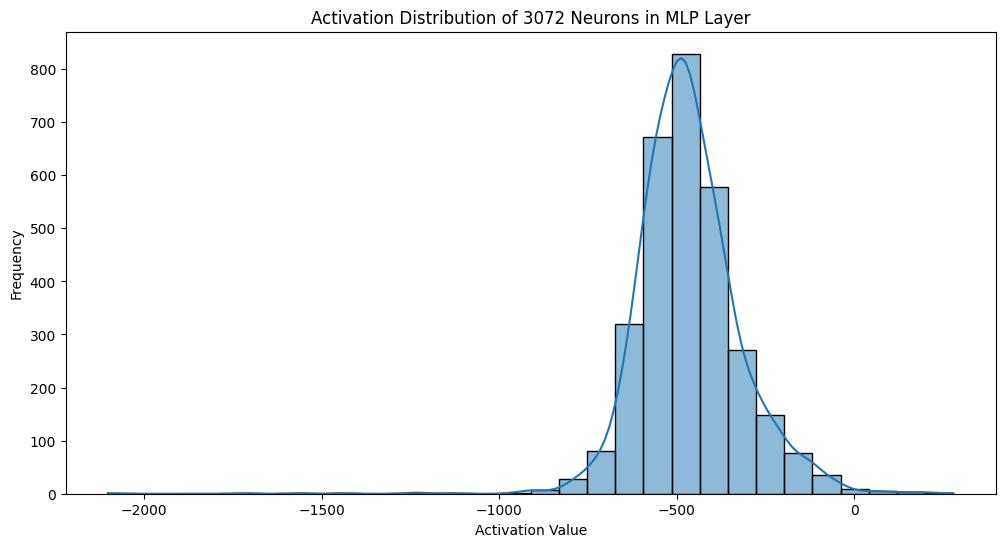

In [39]:
# plot values of activations

plt.figure(figsize=(12, 6))
sns.histplot(total_activation, kde=True, bins=30)
plt.title("Activation Distribution of 3072 Neurons in MLP Layer")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.show()


A normal distributions is observed. This shows that some neurons exhibit more superposition than others, and perhaps some neurons do indeed have thier own dimension assigned for an important feature, assuming the text inputs were generally representative.